In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import s2sphere
import matplotlib.patches as patches
from tqdm import tqdm
import os
from pathlib import Path

## Density Plot

In [6]:
# --- CONFIGURAZIONE ---
FILE_PATH = Path("../../data/metadata/places-classification/train_with_predictions.csv")

# --- CARICAMENTO DATI E MAPPA ---
print("Caricamento dati per la mappa di densità...")
df = pd.read_csv(FILE_PATH)

Caricamento dati per la mappa di densità...


Caricamento mappa USA...


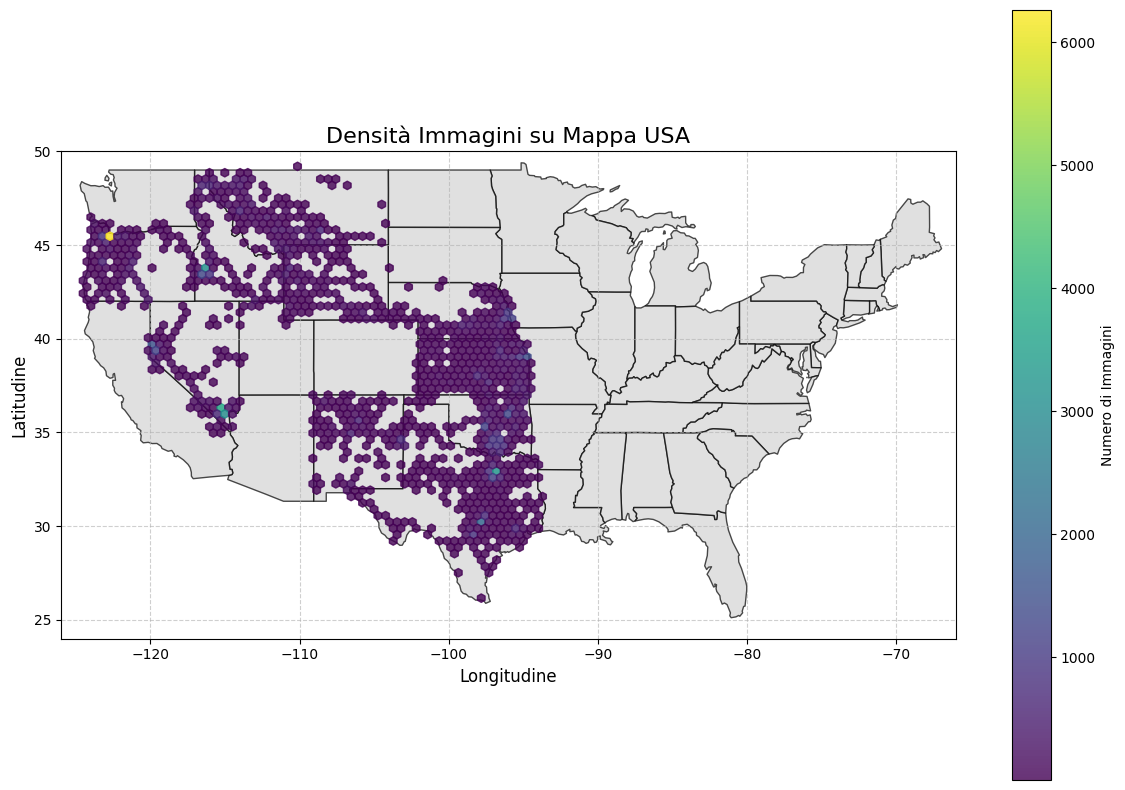


--- Mappa di Densità Completata ---


In [5]:
#Density plot
print("Caricamento mappa USA...")
usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(usa_url)
usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# --- PLOT DELLA DENSITÀ SU MAPPA USA ---
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Disegniamo la mappa degli USA come sfondo
usa.plot(ax=ax, color='lightgray', edgecolor='black', zorder=1, alpha=0.7)

# Hexbin per la densità dei punti
hb = ax.hexbin(df['longitude'], df['latitude'], gridsize=60, cmap='viridis', mincnt=1, alpha=0.8, zorder=2)
plt.colorbar(hb, ax=ax, label='Numero di Immagini')

ax.set_title("Densità Immagini su Mappa USA", fontsize=16)
ax.set_xlabel("Longitudine", fontsize=12)
ax.set_ylabel("Latitudine", fontsize=12)
ax.set_xlim([-126, -66]) # Limiti USA continentali
ax.set_ylim([24, 50])
ax.grid(True, linestyle='--', alpha=0.6) # Aggiungiamo una griglia
plt.tight_layout()
plt.show()

print("\n--- Mappa di Densità Completata ---")

## Partitioning

In [4]:
# --- CONFIGURAZIONE PERCORSI ---
INPUT_TRAIN = "/content/drive/MyDrive/osv5m/datasets/train_with_predictions.csv"
INPUT_TEST = "/content/drive/MyDrive/osv5m/datasets/test_with_predictions.csv"
OUTPUT_TRAIN = "/content/drive/MyDrive/osv5m/datasets/train_with_geocells_labels.csv"
OUTPUT_TEST = "/content/drive/MyDrive/osv5m/datasets/test_with_geocells_labels.csv"


In [5]:
def get_s2_cell_id(lat, lng):
    return s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(lat, lng))

def get_cell_vertices(cell_id):
    cell = s2sphere.Cell(cell_id)
    vertices = []
    for i in range(4):
        vertex = s2sphere.LatLng.from_point(cell.get_vertex(i))
        vertices.append((vertex.lng().degrees, vertex.lat().degrees))
    return vertices

def fast_assign_label(point_s2_id, lookup_dict):
    for lvl in range(30, 3, -1):
        parent_token = point_s2_id.parent(lvl).to_token()
        if parent_token in lookup_dict:
            return lookup_dict[parent_token]
    return '-1' # Modified to return a string '-1'

def run_partitioning(df_points, tau_max, start_level=4):
    leaf_cells_result = []
    def partition(cell_id, points):
        count = len(points)
        if count <= tau_max or cell_id.level() >= 30:
            if count > 0:
                leaf_cells_result.append({'cell_id': cell_id, 'count': count})
            return
        for i in range(4):
            child = cell_id.child(i)
            child_points = [p for p in points if child.contains(p)]
            if child_points:
                partition(child, child_points)

    initial_cells = df_points['s2_cell'].apply(lambda x: x.parent(start_level)).unique()
    for start_id in initial_cells:
        relevant_points = [p for p in df_points['s2_cell'] if start_id.contains(p)]
        partition(start_id, relevant_points)
    return leaf_cells_result

In [7]:
#Partitioning

# --- CARICAMENTO DATI ---
print("🛰️ Caricamento dati...")
df = pd.read_csv(INPUT_TRAIN)
df['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df['latitude'], df['longitude'])]


# --- TRAIN-VAL SPLIT ---

# 80%-15% train-val splitting indices

np.random.seed(42)

split_ratio = 0.85

train_len = int(split_ratio*len(df))

train_indices = np.sort(np.random.choice(len(df), size=train_len, replace=False))

print(f"Train set size: {train_len}")

df['is_train'] = 0
df.loc[train_indices, 'is_train'] = 1 # Corrected chained assignment

df_train = df[df['is_train']==1].copy() # Ensure df_train is a copy to avoid SettingWithCopyWarning


# --- CONFIGURAZIONI ---
configs = [
    {"name": "config_1", "tau_max": 50},
    {"name": "config_2", "tau_max": 100},
    {"name": "config_3", "tau_max": 200}
]

trained_partitions = {} # Qui salviamo le liste di leaf_cells per il plot
trained_lookups = {}    # Qui salviamo i dizionari per il matching veloce

for cfg in configs:
    print(f"\n🔄 Partizionamento {cfg['name']} (tau_max={cfg['tau_max']})...")

    # 1. Calcolo celle foglia
    leaves = run_partitioning(df_train, cfg['tau_max'])
    trained_partitions[cfg['name']] = leaves

    # --- AGGIUNTA: Stampa del numero di celle create ---
    num_cells = len(leaves)
    print(f"✅ Numero di celle (classi) create: {num_cells}")
    # --------------------------------------------------

    # 2. Creazione lookup e assegnazione labels
    # Modified to use cell_id.to_token() as the label instead of an integer index
    lookup = {leaf['cell_id'].to_token(): leaf['cell_id'].to_token() for leaf in leaves}
    trained_lookups[cfg['name']] = lookup

    col_name = f"label_{cfg['name']}"
    df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc="   Mapping")] # Corrected chained assignment

print("\n✅ Calcolo completato.")



🛰️ Caricamento dati...
Train set size: 101156

🔄 Partizionamento config_1 (tau_max=50)...
✅ Numero di celle (classi) create: 4742


   Mapping: 100%|██████████| 101156/101156 [00:11<00:00, 9152.86it/s] 



🔄 Partizionamento config_2 (tau_max=100)...
✅ Numero di celle (classi) create: 2509


   Mapping: 100%|██████████| 101156/101156 [00:04<00:00, 21134.62it/s]



🔄 Partizionamento config_3 (tau_max=200)...
✅ Numero di celle (classi) create: 1337


   Mapping: 100%|██████████| 101156/101156 [00:05<00:00, 17904.14it/s]


✅ Calcolo completato.


In [23]:
# # Generazione mappe per visualizzare le celle create per ogni partizione

# print("🗺️ Generazione mappe...")
# usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
# usa = gpd.read_file(usa_url)
# usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# fig, axes = plt.subplots(len(configs), 1, figsize=(15, 8 * len(configs)))
# if len(configs) == 1: axes = [axes]

# for i, cfg in enumerate(configs):
#     ax = axes[i]
#     name = cfg['name']
#     leaf_cells = trained_partitions[name]

#     usa.plot(ax=ax, color='#f2f2f2', edgecolor='#999999', zorder=1)
#     ax.scatter(df_train['longitude'], df_train['latitude'], s=0.5, color='blue', alpha=0.1, zorder=2)

#     for leaf in leaf_cells:
#         verts = get_cell_vertices(leaf['cell_id'])
#         polygon = patches.Polygon(verts, linewidth=0.6, edgecolor='red', facecolor='none', alpha=0.8, zorder=3)
#         ax.add_patch(polygon)

#     ax.set_title(f"{name} | tau_max={cfg['tau_max']} | Classi: {len(leaf_cells)}")
#     ax.set_xlim([-126, -66]); ax.set_ylim([24, 50])

# plt.tight_layout()
# plt.show()

In [8]:
df_train.head()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_city,unique_country,creator_username,creator_id,predicted_label,s2_cell,is_train,label_config_1,label_config_2,label_config_3
0,175846147796767,31.807977,-109.051129,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743210350,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cde1b03a05,1,86d99,86d99,86d9
1,327253605472404,31.805039,-109.053170,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743197630,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d1b8c7fbd3,1,86d99,86d99,86d9
3,815733012693812,31.839720,-109.029062,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300841441,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,CellId: 86d990591818b4a1,1,86d99,86d99,86d9
4,471207127297520,31.812350,-109.048174,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743448990,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cc873be437,1,86d99,86d99,86d9
6,1482670018574640,31.834722,-109.032378,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300880086,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,CellId: 86d9905a63f65097,1,86d99,86d99,86d9


In [18]:
# Elaborazione e Salvataggio validation
df_val = df[df['is_train']==0].copy()
df_val['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df_val['latitude'], df_val['longitude'])]

for cfg in configs:
    name = cfg['name']
    lookup = trained_lookups[name]
    df_val[f"label_{name}"] = [fast_assign_label(p, lookup) for p in tqdm(df_val['s2_cell'], desc=f"   Matching {name}")]

df_val.drop(columns=['s2_cell'])



   Matching config_3: 100%|██████████| 17852/17852 [00:01<00:00, 11235.82it/s]


,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_sub-region,unique_city,unique_country,creator_username,creator_id,predicted_label,is_train,label_config_1,label_config_2,label_config_3
2,4079391105448884,31.795616,-109.059784,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743526750,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,0,86d99,86d99,86d9
5,731481427539108,31.836914,-109.030890,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300863012,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,0,86d99,86d99,86d9
15,463131271634744,32.242252,-109.111987,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,z_w1XN05TwqG-VTT_wjKvQ,1459886248250,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,0,86d9b5,86d9b,86d9
22,711217672935814,32.260516,-109.201080,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,qeBfYCP_RZecEeCQ7ry3dQ,1459882930830,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,0,86d9d,86d9d,86d9
26,1278861535843068,32.265820,-109.224079,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,bKq2TFsSTkOrfS-pCSWmuA,1459882833730,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,0,86d9d,86d9d,86d9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118983,524041328967325,35.921845,-116.434287,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,JIPGrx3Ns5G4P3NgMB4I0c,1582829596000,16.0,67.0,"(16, 67)",...,Nye County_Nevada_US,Pahrump_Nye County_Nevada_US,US,hshearer,1.002157e+14,Natural,0,80c6c,80c6c,80c6c
118986,476541513595411,36.243425,-115.107916,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,s9jssypgqlup741wub828s,1575749726851,17.0,67.0,"(17, 67)",...,Clark County_Nevada_US,North Las Vegas_Clark County_Nevada_US,US,ryne,1.093419e+14,Urban,0,80c8e81,80c8e84,80c8e84
118987,466518361100977,38.099642,-117.327205,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,8r0560ca41xy5w4t3ny7rh,1543187375805,16.0,68.0,"(16, 68)",...,Nye County_Nevada_US,Tonopah_Nye County_Nevada_US,US,lvl5,1.044090e+14,Natural,0,80bc1,80bc4,80bd
118990,586804372723072,39.594686,-119.169628,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,0mzc76l6mwznrwu4ptccmw,1532096146564,16.0,70.0,"(16, 70)",...,Lyon County_Nevada_US,Fernley_Lyon County_Nevada_US,US,lvl5,1.044090e+14,Natural,0,8098e9c,8098ec,8098f


In [23]:
# Salvataggio TRAIN E VALUTAZIONE COMBINATI
OUTPUT_TRAIN = "/content/drive/MyDrive/osv5m/datasets/train_val_final.csv"

# Concatena df_train e df_val per creare il DataFrame finale
df_final = pd.concat([df_train, df_val], ignore_index=True)


df_final.head()
#print("💾 Salvataggio Train e Valutazione Combinati...")
df_final.to_csv(OUTPUT_TRAIN, index=False)

In [13]:
# Elaborazione e Salvataggio TEST
if os.path.exists(INPUT_TEST):
    print("🧪 Elaborazione Test Set...")
    df_test = pd.read_csv(INPUT_TEST)
    df_test['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df_test['latitude'], df_test['longitude'])]

    for cfg in configs:
        name = cfg['name']
        lookup = trained_lookups[name]
        df_test[f"target_label_{name}"] = [fast_assign_label(p, lookup) for p in tqdm(df_test['s2_cell'], desc=f"   Matching {name}")]

    df_test.drop(columns=['s2_cell']).to_csv(OUTPUT_TEST, index=False)
    print(f"✅ File salvati:\n - {OUTPUT_TRAIN}\n - {OUTPUT_TEST}")
else:
    print("⚠️ File test non trovato, salvato solo il train.")

🧪 Elaborazione Test Set...


   Matching config_3: 100%|██████████| 10110/10110 [00:00<00:00, 18180.03it/s]


✅ File salvati:
 - /content/drive/MyDrive/osv5m/datasets/train_val_final.csv
 - /content/drive/MyDrive/osv5m/datasets/test_with_geocells_labels.csv


## Center dataset creation

In [17]:
# Re-define configs and re-calculate cell_centers_by_config to ensure availability
configs = [
    {"name": "config_1", "tau_max": 50},
    {"name": "config_2", "tau_max": 100},
    {"name": "config_3", "tau_max": 200}
]

cell_centers_by_config = {}

print("🌍 Ricostruzione dei centri delle celle per ogni configurazione...")

for cfg in configs:
    name = cfg['name']
    leaf_cells = trained_partitions[name]

    cell_centers = []
    for leaf in tqdm(leaf_cells, desc=f"  Processing {name} cells"):
        cell_id = leaf['cell_id']
        latlng = cell_id.to_lat_lng()
        center_lat = latlng.lat().degrees
        center_lng = latlng.lng().degrees
        cell_centers.append({
            'cell_id_token': cell_id.to_token(),
            'center_latitude': center_lat,
            'center_longitude': center_lng,
            'count': leaf['count']
        })
    cell_centers_by_config[name] = pd.DataFrame(cell_centers)

# Creazione di un unico DataFrame combinato
all_cell_data = []

for cfg_name, df_centers in cell_centers_by_config.items():
    df_centers['config_name'] = cfg_name
    all_cell_data.append(df_centers)

# Concatenazione di tutti i DataFrame in uno singolo
combined_cell_df = pd.concat(all_cell_data, ignore_index=True)

print("📊 DataFrame Combinato dei Centri delle Celle (primi 5):")
display(combined_cell_df.head())

print(f"\nTotale righe nel DataFrame combinato: {len(combined_cell_df)}")


🌍 Ricostruzione dei centri delle celle per ogni configurazione...


  Processing config_3 cells: 100%|██████████| 1337/1337 [00:00<00:00, 61314.74it/s]

📊 DataFrame Combinato dei Centri delle Celle (primi 5):


,cell_id_token,center_latitude,center_longitude,count,config_name
0,86d84,32.648380,-109.188005,5,config_1
1,86d904,32.286026,-108.712579,42,config_1
2,86d914,32.139738,-108.522571,1,config_1
3,86d91c,32.314937,-108.522571,8,config_1
4,86d99,31.804084,-108.997769,6,config_1



Totale righe nel DataFrame combinato: 8588


In [18]:
output_cell_center_path = "/content/drive/MyDrive/osv5m/datasets/cell_center_dataset.csv"
combined_cell_df.to_csv(output_cell_center_path, index=False)
print(f"✅ File salvato: {output_cell_center_path}")

✅ File salvato: /content/drive/MyDrive/osv5m/datasets/cell_center_dataset.csv


In [21]:
import pandas as pd
import numpy as np
import s2sphere
from tqdm import tqdm

# Assuming get_s2_cell_id is defined in a previous cell
# Assuming run_partitioning is defined in a previous cell

def get_s2_cell_id(lat, lng):
    return s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(lat, lng))

def get_cell_vertices(cell_id):
    cell = s2sphere.Cell(cell_id)
    vertices = []
    for i in range(4):
        vertex = s2sphere.LatLng.from_point(cell.get_vertex(i))
        vertices.append((vertex.lng().degrees, vertex.lat().degrees))
    return vertices

def fast_assign_label(point_s2_id, lookup_dict):
    for lvl in range(30, 3, -1):
        parent_token = point_s2_id.parent(lvl).to_token()
        if parent_token in lookup_dict:
            return lookup_dict[parent_token]
    return '-1' # Modified to return a string '-1'

def run_partitioning(df_points, tau_max, start_level=4):
    leaf_cells_result = []
    def partition(cell_id, points):
        count = len(points)
        if count <= tau_max or cell_id.level() >= 30:
            if count > 0:
                leaf_cells_result.append({'cell_id': cell_id, 'count': count})
            return
        for i in range(4):
            child = cell_id.child(i)
            child_points = [p for p in points if child.contains(p)]
            if child_points:
                partition(child, child_points)

    initial_cells = df_points['s2_cell'].apply(lambda x: x.parent(start_level)).unique()
    for start_id in initial_cells:
        relevant_points = [p for p in df_points['s2_cell'] if start_id.contains(p)]
        partition(start_id, relevant_points)
    return leaf_cells_result


# --- CARICAMENTO DATI ---
print("🛰️ Caricamento dati...")
df = pd.read_csv(INPUT_TRAIN)
df['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df['latitude'], df['longitude'])]


# --- TRAIN-VAL SPLIT ---

# 80%-15% train-val splitting indices

np.random.seed(42)

split_ratio = 0.85

train_len = int(split_ratio*len(df))

train_indices = np.sort(np.random.choice(len(df), size=train_len, replace=False))

print(f"Train set size: {train_len}")

df['is_train'] = 0
df.loc[train_indices, 'is_train'] = 1 # Corrected chained assignment

df_train = df[df['is_train']==1].copy() # Ensure df_train is a copy to avoid SettingWithCopyWarning


# --- CONFIGURAZIONI ---
configs = [
    {"name": "config_1", "tau_max": 50},
    {"name": "config_2", "tau_max": 100},
    {"name": "config_3", "tau_max": 200}
]

trained_partitions = {} # Qui salviamo le liste di leaf_cells per il plot
trained_lookups = {}    # Qui salviamo i dizionari per il matching veloce

for cfg in configs:
    print(f"\n🔄 Partizionamento {cfg['name']} (tau_max={cfg['tau_max']})...")

    # 1. Calcolo celle foglia
    leaves = run_partitioning(df_train, cfg['tau_max'])
    trained_partitions[cfg['name']] = leaves

    # --- AGGIUNTA: Stampa del numero di celle create ---
    num_cells = len(leaves)
    print(f"✅ Numero di celle (classi) create: {num_cells}")
    # --------------------------------------------------

    # 2. Creazione lookup e assegnazione labels
    # Modified to use cell_id.to_token() as the label instead of an integer index
    lookup = {leaf['cell_id'].to_token(): leaf['cell_id'].to_token() for leaf in leaves}
    trained_lookups[cfg['name']] = lookup

    col_name = f"label_{cfg['name']}"
    df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc="   Mapping")] # Corrected chained assignment

print("\n✅ Calcolo completato.")

🛰️ Caricamento dati...
Train set size: 101156

🔄 Partizionamento config_1 (tau_max=50)...
✅ Numero di celle (classi) create: 4742


   Mapping: 100%|██████████| 119008/119008 [00:05<00:00, 21656.92it/s]



🔄 Partizionamento config_2 (tau_max=100)...
✅ Numero di celle (classi) create: 2509


   Mapping: 100%|██████████| 119008/119008 [00:06<00:00, 17767.18it/s]



🔄 Partizionamento config_3 (tau_max=200)...
✅ Numero di celle (classi) create: 1337


   Mapping: 100%|██████████| 119008/119008 [00:06<00:00, 17749.60it/s]


✅ Calcolo completato.


In [22]:
df.head()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_city,unique_country,creator_username,creator_id,predicted_label,s2_cell,is_train,label_config_1,label_config_2,label_config_3
0,175846147796767,31.807977,-109.051129,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743210350,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cde1b03a05,1,86d99,86d99,86d9
1,327253605472404,31.805039,-109.053170,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743197630,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d1b8c7fbd3,1,86d99,86d99,86d9
2,4079391105448884,31.795616,-109.059784,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743526750,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d866b60f6b,0,86d99,86d99,86d9
3,815733012693812,31.839720,-109.029062,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300841441,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,CellId: 86d990591818b4a1,1,86d99,86d99,86d9
4,471207127297520,31.812350,-109.048174,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743448990,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cc873be437,1,86d99,86d99,86d9


In [20]:
OUTPUT_TRAIN = "/content/drive/MyDrive/osv5m/datasets/train_val_final.csv"

# Merging df_train with df with NA for the missing validation columns
df_final = pd.merge(df, df_train[['s2_cell', 'label_config_1', 'label_config_2', 'label_config_3']], how='left')

print("💾 Salvataggio Train Set...")
df_final.to_csv(OUTPUT_TRAIN, index=False)

💾 Salvataggio Train Set...


In [ ]:
# Elaborazione e Salvataggio TEST
if os.path.exists(INPUT_TEST):
    print("🧪 Elaborazione Test Set...")
    df_test = pd.read_csv(INPUT_TEST)
    df_test['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df_test['latitude'], df_test['longitude'])]

    for cfg in configs:
        name = cfg['name']
        lookup = trained_lookups[name]
        df_test[f"target_label_{name}"] = [fast_assign_label(p, lookup) for p in tqdm(df_test['s2_cell'], desc=f"   Matching {name}")]

    df_test.drop(columns=['s2_cell']).to_csv(OUTPUT_TEST, index=False)
    print(f"✅ File salvati:\n - {OUTPUT_TRAIN}\n - {OUTPUT_TEST}")
else:
    print("⚠️ File test non trovato, salvato solo il train.")

🧪 Elaborazione Test Set...


   Matching config_3: 100%|██████████| 10110/10110 [00:01<00:00, 9718.19it/s]


✅ File salvati:
 - /content/drive/MyDrive/osv5m/datasets/train_val_final.csv
 - /content/drive/MyDrive/osv5m/datasets/test_with_geocells_labels.csv


In [ ]:
import pandas as pd
import numpy as np
import s2sphere
from tqdm import tqdm

# Caricamento dei file salvati su Drive
train_path = OUTPUT_TRAIN
test_path = OUTPUT_TEST

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

configs = [
    {"name": "config_1", "tau_max": 50},
    {"name": "config_2", "tau_max": 100},
    {"name": "config_3", "tau_max": 200}
]

print("df_train head:")
display(df_train.head())
print("\ndf_test head:")
display(df_test.head())

print("\n\n❐ --- CONTEGGIO IMMAGINI NON ASSEGNATE (LABEL -1) --- ❐\n")

for cfg in configs:
    train_col = f"label_{cfg['name']}"
    test_col = f"target_label_{cfg['name']}"

    print(f"📊 {cfg['name'].upper()}:")

    # Conteggio per il TRAIN
    n_minus_1_train = (df_train[train_col] == '-1').sum()
    perc_train = (n_minus_1_train / len(df_train)) * 100
    print(f"   [TRAIN] Immagini con -1: {n_minus_1_train} su {len(df_train)} ({perc_train:.2f}%) ")

    # Conteggio per il TEST
    if test_col in df_test.columns:
        n_minus_1_test = (df_test[test_col] == '-1').sum()
        perc_test = (n_minus_1_test / len(df_test)) * 100
        print(f"   [TEST ] Immagini con -1: {n_minus_1_test} su {len(df_test)} ({perc_test:.2f}%) ")

    print("-" * 40)


df_train head:


,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_city,unique_country,creator_username,creator_id,predicted_label,s2_cell,is_train,label_config_1,label_config_2,label_config_3
0,175846147796767,31.807977,-109.051129,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743210350,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cde1b03a05,1,86d99,86d99,86d9
1,327253605472404,31.805039,-109.053170,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743197630,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d1b8c7fbd3,1,86d99,86d99,86d9
2,4079391105448884,31.795616,-109.059784,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743526750,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d866b60f6b,0,NaN,NaN,NaN
3,815733012693812,31.839720,-109.029062,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300841441,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,CellId: 86d990591818b4a1,1,86d99,86d99,86d9
4,471207127297520,31.812350,-109.048174,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743448990,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cc873be437,1,86d99,86d99,86d9



df_test head:


,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_sub-region,unique_region,unique_country,quadtree_10_1000,creator_username,creator_id,predicted_label,target_label_config_1,target_label_config_2,target_label_config_3
0,1149142498937955,33.076249,-107.307924,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,vxYv3acjdLq3C-PonflwGg,1514582785668,19.0,65.0,"(19, 65)",...,Sierra County_New Mexico_US,New Mexico_US,US,2400,james_mapillary,1.077295e+14,Natural,86df4,86df4,86df4
1,530975244564913,33.756863,-98.857817,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,Us5lT6SS5UwyXSeqvyIWrA,1566834580000,21.0,65.0,"(21, 65)",...,Archer County_Texas_US,Texas_US,US,2444,fta,1.004782e+14,Natural,8653,8653,8653
2,364891741617690,46.876285,-112.083571,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crLSZTuQn8b5tCQNgRggBQ,1454853906828,18.0,75.0,"(18, 75)",...,Lewis and Clark County_Montana_US,Montana_US,US,5192,drkludge,1.106021e+14,Natural,53433,53433,53433
3,1134460720387154,37.826379,-96.894420,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,cp18y4qeemjv3qmtdhlgfg,1478958427000,22.0,68.0,"(22, 68)",...,Butler County_Kansas_US,Kansas_US,US,2913,toebee,1.096903e+14,Natural,87bbb,87bbb,87bbb
4,168140228443695,46.296038,-113.315821,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,eNfRUn9PxXH3O5Bm4qlCjQ,1473983600670,17.0,75.0,"(17, 75)",...,Granite County_Montana_US,Montana_US,US,5183,chrisbeddow,1.058675e+14,Natural,-1,-1,-1




❐ --- CONTEGGIO IMMAGINI NON ASSEGNATE (LABEL -1) --- ❐

📊 CONFIG_1:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%) 
   [TEST ] Immagini con -1: 879 su 10110 (8.69%) 
----------------------------------------
📊 CONFIG_2:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%) 
   [TEST ] Immagini con -1: 417 su 10110 (4.12%) 
----------------------------------------
📊 CONFIG_3:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%) 
   [TEST ] Immagini con -1: 196 su 10110 (1.94%) 
----------------------------------------
